In [1]:
import shutil
import tempfile

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as date
import seaborn as sns
from scipy import stats
from scipy.signal import kaiserord, filtfilt, firwin
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from sklearn import linear_model
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor

sns.set_context('talk')
np.random.seed(1)

Using TensorFlow backend.


In [2]:
data_crime_raw = (pd.read_csv('.\\NYPD_Complaint_Data_Historic.csv',
                             usecols=['CMPLNT_FR_DT', 'LAW_CAT_CD', 'BORO_NM'],
                             dtype={'LAW_CAT_CD':'category', 'BORO_NM':'category'},
                             parse_dates=['CMPLNT_FR_DT'],
                             date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='coerce'))
                  .rename(columns={'CMPLNT_FR_DT': 'date', 'LAW_CAT_CD': 'crime_type', 'BORO_NM': 'borough'}))

In [3]:
data_311_raw = (pd.read_csv('.\\311_Service_Requests_from_2010_to_Present.csv',
                           usecols=['Created Date', 'Complaint Type', 'Borough'],
                           dtype={'Complaint Type':'category', 'Borough':'category',
                                  'Latitude':float, 'Longitude':float},
                           parse_dates=['Created Date'],
                           date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y %I:%M:%S %p', errors='coerce'))
                .rename(columns={'Created Date': 'date', 'Complaint Type': '311type', 'Borough': 'borough'}))

In [2]:
data_crime_raw.to_pickle('data_crime_raw.pickle')
data_311_raw.to_pickle('data_311_raw.pickle')

NameError: name 'data_crime_raw' is not defined

In [2]:
data_crime_raw = pd.read_pickle('data_crime_raw.pickle')
data_311_raw = pd.read_pickle('data_311_raw.pickle')

In [3]:
data_crime = data_crime_raw[data_crime_raw.date >= pd.to_datetime(dt.date(2010,1,1))].dropna()
data_311 = data_311_raw[data_311_raw.date < pd.to_datetime(dt.date(2016,1,1))].dropna()

data_crime = data_crime[data_crime.crime_type != 'VIOLATION'].drop('crime_type', 1)
data_311 = data_311[data_311.borough != 'Unspecified']
data_311.borough.cat.remove_unused_categories(inplace=True)

In [4]:
boros = data_crime['borough'].cat.categories.tolist()
d_c_boro = {}
d_311_boro = {}
data = {}

for boro in boros:
    d_c_boro[boro] = data_crime[data_crime['borough']==boro].groupby([
        pd.TimeGrouper(key='date', freq='D')]).size()
    d_c_boro[boro].name = 'crime'
    d_311_boro[boro] = data_311[data_311['borough']==boro].groupby([
        pd.TimeGrouper(key='date', freq='D')])['311type'].value_counts().unstack().fillna(0)

In [5]:
thresh = .5
d_311_boro2 = {}

for boro in boros:
    to_del=[]
    for col in d_311_boro[boro].columns.tolist():
        counts = d_311_boro[boro][col].value_counts()
        if 0 in counts.index:
            if counts.loc[0]/len(d_311_boro[boro]) > thresh:
                to_del.append(col)
    d_311_boro2[boro] = d_311_boro[boro].drop(to_del, 1)

In [6]:
data_merged = {}

for boro in boros:
    data_merged[boro] = d_311_boro2[boro].join(d_c_boro[boro])

In [7]:
#A Kaiser window is used, kaiserord calculates beta parameter for window and optimal number of taps for filter
#Firwin calculates N taps (with N optimally calculated by kaiserord)
#filtfilt convolutes taps forward, and then backward to avoid data lag

nyq_rate = 0.5
width = 0.1/nyq_rate
ripple_db = 1000.0
N, beta = kaiserord(ripple_db, width)
max_day = 30

cutoff_hz = (1/max_day)/nyq_rate

taps = firwin(N, cutoff_hz, window=('kaiser', beta), pass_zero=True)

filt={}
data_filt = {}

for boro in boros:
    filt[boro] = np.array(data_merged[boro].apply(lambda x: filtfilt(taps, 1.0, x)))
    data_filt[boro] = np.array(data_merged[boro] - filt[boro])

In [8]:
for boro in boros:
    print(boro+': ')
    print((data_merged[boro] - filt[boro]).corr().abs()['crime'].nlargest(5)[1:])
    print('\n')

BRONX: 
Street Condition      0.254346
Dirty Conditions      0.228391
Consumer Complaint    0.205797
Noise                 0.179262
Name: crime, dtype: float64


BROOKLYN: 
Street Light Condition    0.180304
Electrical                0.176462
Dirty Conditions          0.171368
Building/Use              0.166599
Name: crime, dtype: float64


MANHATTAN: 
Broken Muni Meter    0.311650
Illegal Parking      0.271691
Vending              0.258651
Noise                0.252069
Name: crime, dtype: float64


QUEENS: 
HEATING                              0.146463
Sidewalk Condition                   0.111989
Missed Collection (All Materials)    0.111600
Blocked Driveway                     0.099610
Name: crime, dtype: float64


STATEN ISLAND: 
Sanitation Condition                 0.094948
Noise                                0.093543
Missed Collection (All Materials)    0.073761
Street Condition                     0.073656
Name: crime, dtype: float64




In [9]:
for boro in boros:
    print(boro+': ')
    print(data_merged[boro].sum().nlargest(5)[1:])
    print('\n')

BRONX: 
Noise - Residential       223360.0
HEATING                   195284.0
Street Light Condition    117547.0
PLUMBING                  116173.0
dtype: float64


BROOKLYN: 
Noise - Residential       275287.0
HEATING                   190325.0
Street Light Condition    166968.0
Street Condition          166337.0
dtype: float64


MANHATTAN: 
Noise - Residential    204568.0
HEATING                137525.0
Noise                  119880.0
Street Condition       108776.0
dtype: float64


QUEENS: 
Street Light Condition    188913.0
Noise - Residential       176335.0
Street Condition          170839.0
Blocked Driveway          161115.0
dtype: float64


STATEN ISLAND: 
Street Condition          76901.0
Street Light Condition    35793.0
Water System              32982.0
Sewer                     27435.0
dtype: float64




In [10]:
new_features = {}

ward = FeatureAgglomeration(n_clusters=10)

for boro in boros:
    new_features[boro] = ward.fit_transform(data_filt[boro][:,:-1])

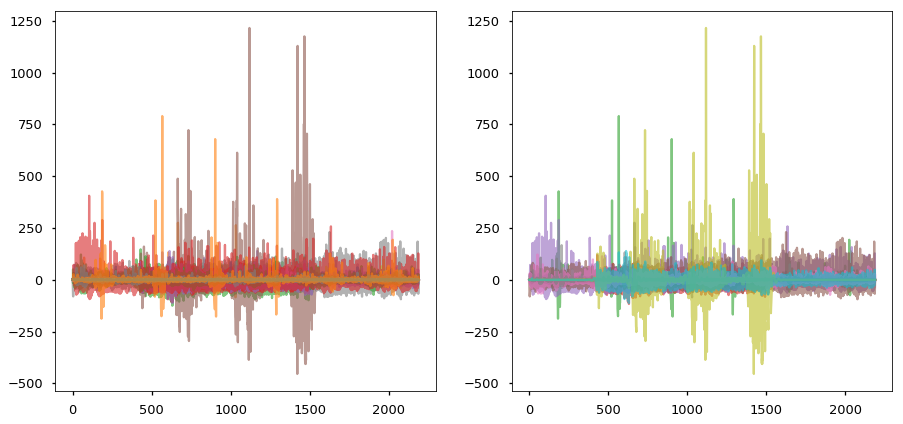

In [11]:
fig, ax = plt.subplots(1, ncols=2, figsize = (15, 7))

for feature in data_filt['BRONX'][:, :-1].T:
    ax[0].plot(feature, alpha=0.6)
    
for feature in new_features['BRONX'].T:
    ax[1].plot(feature, alpha=0.6)
    
plt.show()

In [12]:
data_merged2 = {}

for boro in boros:
    new_featuresdf = pd.DataFrame(new_features[boro], index=data_merged[boro].index)
    d_c_series = pd.Series(data_filt[boro][:,-1], index=data_merged[boro].index, name='crime')
    
    data_merged2[boro] = new_featuresdf.join(d_c_series)

In [13]:
data_scaled = {}
scaler = {}

for boro in boros:
    scaler[boro] = RobustScaler()
    data_scaled[boro] = scaler[boro].fit_transform(data_merged2[boro])

In [ ]:
regr = {}
regr_base = {}
X_test = {}
Y_test = {}
split_ind = {}

for i, boro in enumerate(boros):
    split_ind[boro] = int(len(data_scaled[boro]) * .9)
    # Split the data into training/testing sets
    X_train = data_scaled[boro][:split_ind[boro], :-1]
    X_test[boro] = data_scaled[boro][split_ind[boro]:, :-1]
    
    Y_train = data_scaled[boro][:split_ind[boro], -1]
    Y_test[boro] = data_scaled[boro][split_ind[boro]:, -1]

    # Create linear regression object
    regr_base[boro] = linear_model.LinearRegressor()
    regr[boro] = BaggingRegressor(base_estimator=regr_base[boro],
                                  n_estimators=1000,
                                  max_samples=0.5,
                                  max_features=0.5,
                                  warm_start=True)

    # Train the model using the training sets
    regr[boro].fit(X_train, Y_train)

In [13]:
linpredY = {}

for boro in boros:
    linpredY[boro] = regr[boro].predict(X_test[boro])

In [14]:
lintest_data = {}
linpred_data = {}

for boro in boros:
    lintest_data[boro] = np.append(X_test[boro], np.reshape(Y_test[boro], (Y_test[boro].shape[0], 1)), axis=1)
    linpred_data[boro] = np.append(X_test[boro], np.reshape(linpredY[boro], (linpredY[boro].shape[0], 1)), axis=1)

In [15]:
lintest_data2 = {}
linpred_data2 = {}

for boro in boros:
    lintest_data2[boro] = scaler[boro].inverse_transform(lintest_data[boro])[:, -1]
    linpred_data2[boro] = scaler[boro].inverse_transform(linpred_data[boro])[:, -1]

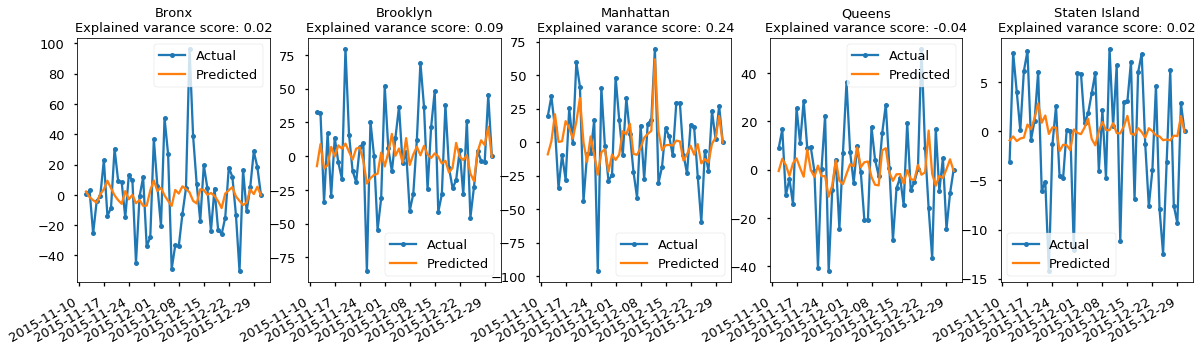

In [51]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
to_plot=50

for i, boro in enumerate(boros):
    ax[i].plot(data_merged2[boro][-to_plot:].index, lintest_data2[boro][-to_plot:],
               '-o', label='Actual', ms=5)
    ax[i].plot(data_merged2[boro][-to_plot:].index, linpred_data2[boro][-to_plot:], label='Predicted')

    ax[i].legend()
    ax[i].set_title(boro.title()+
                    f'\nExplained varance score: {explained_variance_score(Y_test[boro], linpredY[boro]):.2f}',
                   fontsize=13)

fig.autofmt_xdate()
plt.show()
fig.subplots_adjust(left=0.05, right=.99)
fig.savefig('Linear Model.png', format='png', dpi=200)

In [60]:
lookback = 5
dataX = {}
dataY = {}

for boro in boros:
    tmpx = data_scaled[boro][:,:-1]
    tmpy = data_scaled[boro][:,-1]
    dataX[boro] = []
    dataY[boro] = []
    
    for i in range(len(tmpx)-lookback-1):
        dataX[boro].append(tmpx[i:(i+lookback), :])
        dataY[boro].append(tmpy[i+lookback])
    
    dataX[boro] = np.array(dataX[boro])
    dataX[boro] = np.reshape(dataX[boro], (dataX[boro].shape[0], dataX[boro].shape[1], 10))
    dataY[boro] = np.array(dataY[boro])

In [61]:
batch_size=1
model = {}

for boro in boros:
    print(boro.title())

    model[boro] = Sequential()
    model[boro].add(LSTM(64, batch_input_shape=(batch_size, lookback, 10), stateful=True, return_sequences=True, dropout=0.4))
    model[boro].add(LSTM(32, batch_input_shape=(batch_size, lookback, 10), stateful=True, dropout=0.4))
    model[boro].add(Dense(1))

    model[boro].compile(loss='mean_squared_error', optimizer='rmsprop')
    for i in range(10):
        print(f'Epoch {i+1}/10.')
        model[boro].fit(dataX[boro], dataY[boro], epochs=1, batch_size=batch_size, 
                  verbose=1, shuffle=False, validation_split=.2)
        model[boro].reset_states()

Bronx
Epoch 1/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==============================] - 35s - loss: 0.5525 - val_loss: 0.4161
Epoch 2/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==============================] - 31s - loss: 0.4825 - val_loss: 0.3961
Epoch 3/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==============================] - 31s - loss: 0.4544 - val_loss: 0.3867
Epoch 4/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==============================] - 32s - loss: 0.4561 - val_loss: 0.3886
Epoch 5/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==============================] - 34s - loss: 0.4533 - val_loss: 0.3804
Epoch 6/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==============================] - 33s - loss: 0.4390 - val_loss: 0.3961
Epoch 7/10.
Train on 1748 samples, validate on 437 samples
Epoch 1/1
1748/1748 [==

In [62]:
lstmpredY = {}

for boro in boros:
    lstmpredY[boro] = model[boro].predict(dataX[boro], batch_size=1)

In [63]:
lstmtrue_data = {}
lstmpred_data = {}

for boro in boros:
    lastY = len(lstmpredY[boro])+lookback-1

    lstmtrue_data[boro] = data_filt[boro][lookback:lastY, -1]
    lstmpred_data[boro] = np.append(data_scaled[boro][lookback:lastY,:-1], 
                                    np.reshape(lstmpredY[boro][:-1], (lstmpredY[boro][:-1].shape[0], 1)), axis=1)

In [64]:
lstmpredY2 = {}

for boro in boros:
    lstmpredY2[boro] = scaler[boro].inverse_transform(lstmpred_data[boro])[:, -1]

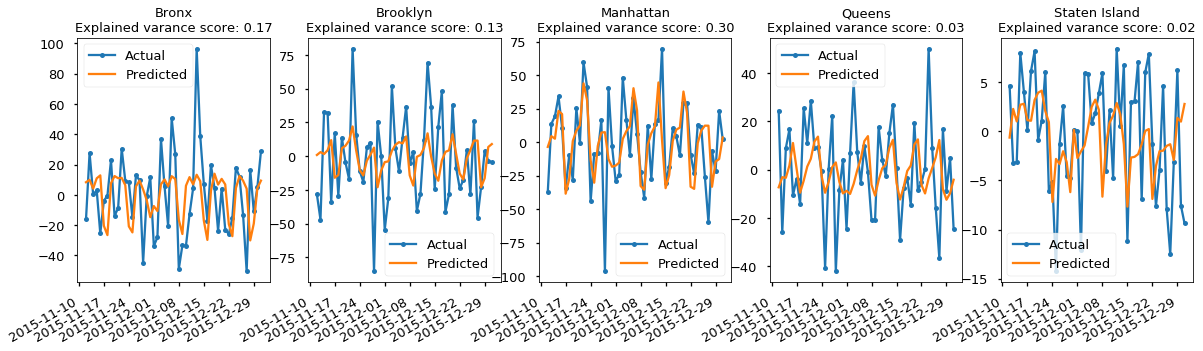

In [66]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
to_plot=50

for i, boro in enumerate(boros):
    ax[i].plot(data_merged2[boro][-to_plot:].index, lstmtrue_data[boro][-to_plot:],
               '-o', label='Actual', ms=5)
    ax[i].plot(data_merged2[boro][-to_plot:].index, lstmpredY2[boro][-to_plot:], label='Predicted')

    ax[i].legend()
    ax[i].set_title(boro.title()+
                    '\nExplained varance score: '
                    f'{explained_variance_score(lstmtrue_data[boro][-200:], lstmpredY2[boro][-200:]):.2f}',
                   fontsize=13)

fig.autofmt_xdate()
plt.show()
fig.subplots_adjust(left=0.05, right=.99)
fig.savefig(f'LSTM - lookback{lookback}.png', format='png', dpi=200)